In [1]:
from numba import float32,int32,int8,jit,cuda
from numba.cuda.random import create_xoroshiro128p_states, xoroshiro128p_uniform_float32,xoroshiro128p_uniform_float64
from numba.cuda.random import xoroshiro128p_normal_float32
from matplotlib import pyplot as plt
import numpy as np
from matplotlib import pyplot as plt
import math
from util import *
import torch
from torch import nn

# Traindata Decompression

In [2]:
@cuda.jit
def decompress2D(inn,states):
    """Inverse function of compress
    Note: This is slightly changed to work with the correct tensor shape"""
    sz,_,sx,sy=states.shape
    #n is which 2d grid ur on, i is which set of 8 numbers you're on
    n,i=cuda.grid(2)
    #get the 2d grid
    state=states[n][0]
    num = inn[n][i]
    for bit in range(8):
        idx=i*8+bit
        x = idx//sy
        y = idx%sy
        #make it a snake pattern. . .
        if x%2==1:
            y=sy-y-1
        state[x][y]=1&(num>>bit)


In [3]:
ngpu=1
device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")
print(device)

cuda:0


# Implementing an EDNN

On an input of shape ($B,C_{in},X_{in},Y_{in}$) == (Batch,channel,spatial dims)

A CNN will apply convolutions to get a tensor of shape ($B,C_{out},X_{out},Y_{out}$), then flatten this tensor 
to shape ($B,C_{out}\cdot X_{out}\cdot Y_{out}$) and apply linear layers to get shape ($B,Z$)

With an EDNN, you can still do a convolution to get shape ($B,C_{out},X_{out},Y_{out}$), but now you want to move the channels to the last dimension to get shape ($B,X_{out},Y_{out},C_{out}$) then apply your linear layers to get shape ($B,X_{out},Y_{out},Z$). Now you can SUM over your spatial dimensions to get shape ($B,Z$).

It is called an Extensive Deep Neural Network (EDNN) because you sum over your spatial dimensions. This way you train a network to learn an extensive quantity of some input size, then transfer that knowledge to a (presumably) larger input size

In [4]:
class EDNN(nn.Module):
    """EDNN model not quite as seen in the paper. For this to be equivalent, then the kernels would need to:
        1. Be fixed
        2. Have no biases
        3. Be all zeros except for one entry which is one
        
        So this EDNN is slightly more general than the one in the paper but basically the same
        
    """
    def __init__(self,f=2,c=1,device=device):
        """Parameters:
            f (int) - Focus (as seen in the paper): This gives stride length for our CNN layer
            c (int) -  Context: This gives padding size in our CNN layer
                Note: For the ednn to work, we set kernel_size = f+2c
            device (torch device) - Device to cast tensors to??
        """
        super(EDNN, self).__init__()
        self.clayer = nn.Conv2d(1,  (f+2*c)**2,(f+2*c),stride=f,padding=c,padding_mode ='circular')
            #Conv2d(in_channels, out_channels, kernel_size, stride=1, padding=0,
            #dilation=1, groups=1, bias=True, padding_mode='zeros', device=None, dtype=None)
        self.linear=nn.Sequential(
            nn.Linear((f+2*c)**2,32),
            nn.ReLU(True),
            nn.Linear(32,64),
            nn.ReLU(True),
            nn.Linear(64,1)
        )
        self.to(device)
    def forward(self, input):
        #apply cnn layer and move the channel dim to the back
        tiled = self.clayer(input).transpose(-1,-3)
        # Apply a linear layer on only the channel dimension
        unsummed=self.linear(tiled)
        #sum over your two spatial dimensions
        summed=unsummed.sum(dim=(-2,-3))
        return summed.squeeze(-1)

In [5]:
class CEDNN(nn.Module):
    def __init__(self,f=[2,2],c=[1,1],channel=[1,16,32],device=device):
        super(CEDNN, self).__init__()
        layers=[]
        for i in range(len(f)):
            layers+=[nn.Conv2d(channel[i],  channel[i+1],(f[i]+2*c[i]),stride=f[i],padding=c[i],padding_mode ='circular')]
            layers+=[nn.ReLU(True)]
        
        self.clayer=nn.Sequential(*layers)
            #Conv2d(in_channels, out_channels, kernel_size, stride=1, padding=0,
            #dilation=1, groups=1, bias=True, padding_mode='zeros', device=None, dtype=None)
        self.linear=nn.Sequential(
            nn.Linear(channel[len(f)],32),
            nn.ReLU(True),
            nn.Linear(32,64),
            nn.ReLU(True),
            nn.Linear(64,1)
        )
        self.to(device)
    def forward(self, input):
        #apply cnn layer and move the channel dim to the back
        tiled = self.clayer(input).transpose(-1,-3)
        # Apply a linear layer on only the channel dimension
        unsummed=self.linear(tiled)
        #sum over your two spatial dimensions
        summed=unsummed.sum(dim=(-2,-3))
        return summed.squeeze(-1)

# Setting up training Parameters

In [6]:
bsize=1024
N=16
modeltype='EDNN'
epoch=400

In [7]:
traindata=np.load('data/big16.npy')
traindata = traindata[np.random.permutation(traindata.shape[0])]
traindata.shape

(102400, 32)

In [8]:
#initialize the network
net=CEDNN() if modeltype=='CEDNN' else EDNN()
#training parameters
lr = 1e-4*bsize/(1024)
beta1 = 0.9
beta2=0.999
#Using adam to optimize
optimizer = torch.optim.Adam(
    net.parameters(), 
    lr=lr, 
    betas=(beta1,beta2)
)

In [9]:
print(net)

EDNN(
  (clayer): Conv2d(1, 16, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), padding_mode=circular)
  (linear): Sequential(
    (0): Linear(in_features=16, out_features=32, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=32, out_features=64, bias=True)
    (3): ReLU(inplace=True)
    (4): Linear(in_features=64, out_features=1, bias=True)
  )
)


# Importing traindata and generating true energies

In [10]:
@cuda.jit
def IsingEnergy(grids,E):
    """Compute Energy of 2D ising lattice (J=1 h=0)"""
    z,i,j=cuda.grid(3)
    sz,sx,sy=grids.shape
    s1=grids[z][i][j]*2-1
    s2=grids[z][(i+1)%sx][j]*2-1
    s3=grids[z][i][(j+1)%sy]*2-1
    cuda.atomic.add(E,z,-s1*s2-s1*s3)

def trueEnergies(grids,N):
    """Compute the true energies of a set of data-compressed ising lattices"""
    testbatch0=torch.zeros([grids.shape[0],1,N,N]).to(device)
    decompress2D[(grids.shape[0],N//2),(1,N//4)](grids,testbatch0)
    testbatch=testbatch0.squeeze(1)
    E=torch.zeros(grids.shape[0]).to(device)
    IsingEnergy[(grids.shape[0],N//8,N//8),(1,8,8)](testbatch,E)
    return testbatch0,E

DATA,LABEL=[a.cpu() for a in trueEnergies(traindata,N)]
DATA.shape

torch.Size([102400, 1, 16, 16])

# Training

In [11]:
Loss = nn.MSELoss()
losses=[]
validation=[]
vidx= traindata.shape[0]//bsize-1
print(vidx)

99


In [12]:

#set the last batch to validation
#this is a super lazy validation set 

count=0
for i in range(epoch):
    #decided the last batch is validation 
    p = np.random.permutation(traindata.shape[0]//bsize)
    t=time.time()
    for idx in p:
        #starting N**2-1 are inputs
        data=DATA[bsize*idx:bsize*(idx+1)].to(device)

        real=LABEL[bsize*idx:bsize*(idx+1)].to(device)
        pred = net(data)
        loss = Loss(pred,real)
        net.zero_grad()
        if idx!=vidx:
            loss.backward()
            optimizer.step()
            losses.append(loss.cpu().item())
        else:
            validation.append(loss.cpu().item())
    if epoch//100==0 or i%(epoch//25)==0:
        print("%.2f"%(np.mean(losses[-p.size-1:])),end="| ")
        

86711.74| 715.65| 300.03| 148.82| 64.64| 29.28| 17.38| 12.02| 9.07| 7.13| 5.79| 4.73| 3.99| 3.39| 2.89| 2.53| 2.17| 1.90| 1.67| 1.48| 1.34| 1.19| 1.07| 0.97| 0.89| 

In [13]:
torch.save(net,"models/%s%d-%d"%(modeltype,N,i))

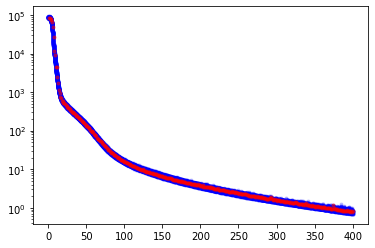

In [14]:
plt.plot(np.arange(len(losses))/vidx,losses,'.',color=(0,0,1,0.2))
plt.plot(np.arange(len(validation))+1,validation,'.',color=(1,0,0,0.5))
plt.yscale("log")
plt.show()
plt.close()

# Importing Testdata

In [15]:
testdata,testlabel=[a.cpu() for a in trueEnergies(np.load('data/testdata32.npy'),32)]
testdata.shape

torch.Size([40960, 1, 32, 32])

In [16]:
def plot_sets(ax0,ax1,c,diff=False,name=''):
    """Creates a plot of predicted vs true energy labels for the rnn
       Since the rnn energy is relative, I set the average rnn ground state energy to the true ground state energy.
       The rest of the energies can then be calculated relative to the ground state.
    """

    
    data=DATA[bsize*vidx:bsize*(vidx+1)].to(device)
    trueE=LABEL[bsize*vidx:bsize*(vidx+1)]
    relE = net(data).detach().cpu()
    
    trueEB = testlabel[::11]
    relEB=net(testdata[::11].to(device)).detach().cpu()
    if diff:
        ax0.plot(trueE,relE-trueE,'.',color=c+[0.1],label=name)
        ax0.plot(trueE,trueE*0,'k--')
        ax1.plot(trueEB,relEB-trueEB,'.',color=c+[0.1],label=name)
        ax1.plot(trueEB,trueEB*0,'k--')
    else:
        ax0.plot(trueE,relE,'.',color=c+[0.1],label=name)
        ax0.plot(trueE,trueE,'k--')
        ax1.plot(trueEB,relEB,'.',color=c+[0.1],label=name)
        ax1.plot(trueEB,trueEB,'k--')

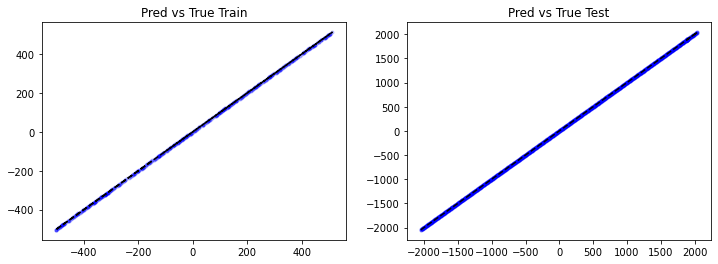

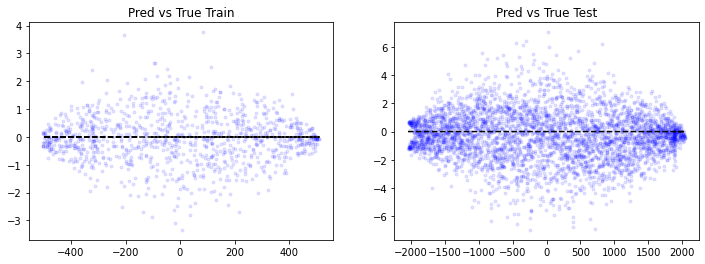

In [17]:
plt.rcParams["figure.figsize"]= [12,4]
fig,(ax0,ax1)=plt.subplots(1,2)
plot_sets(ax0,ax1,[0,0,1],False)
ax0.set_title("Pred vs True Train")
ax1.set_title("Pred vs True Test")
plt.show()

plt.rcParams["figure.figsize"]= [12,4]
fig,(ax0,ax1)=plt.subplots(1,2)
plot_sets(ax0,ax1,[0,0,1],True)
ax0.set_title("Pred vs True Train")
ax1.set_title("Pred vs True Test")
plt.show()